In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ./xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:


env = gym.make("LunarLander-v2").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n
#env.render()
#plt.imshow(env.render("rgb_array"))

In [3]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(50,50),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=3 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


/home/main/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [4]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=60):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states= []
    elite_actions =[]
    for i in range (len(states_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])  
            elite_actions.extend(actions_batch[i])  
    
    return elite_states,elite_actions
    

In [5]:
from IPython.display import clear_output

def show_progress(batch_rewards,log, reward_range=[-990,+1000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward,threshold = np.mean(batch_rewards),np.percentile(batch_rewards,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0])#,label='Mean rewards')
    plt.plot(list(zip(*log))[1])#,label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
  #  plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [6]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions,p = probs)
        
        new_s,r,done,info = env.step(int(a))
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [7]:
from sklearn.externals import joblib


In [8]:
agent = joblib.load("GoodAgent")

mean reward = 69.652, threshold=148.818


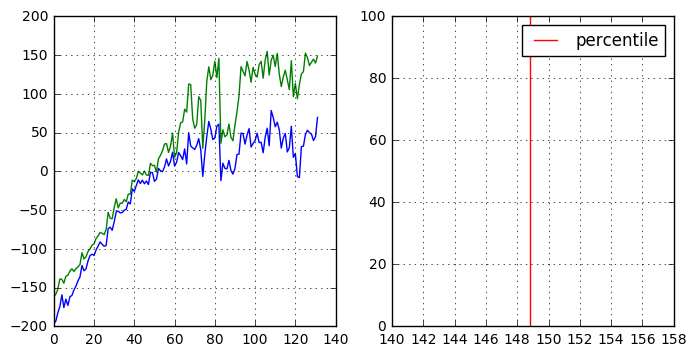

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [47]:
n_sessions = 100
percentile = 65
log = []

for i in range(1000):
    #generate new sessions
    sessions = [generate_session() for i in range (n_sessions)]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    agent.fit(elite_states,elite_actions) 

    show_progress(batch_rewards,log,reward_range=[0,np.max(batch_rewards)])
    
    if np.mean(batch_rewards)> 0:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [9]:
def generate_session_render(env, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions,p = probs)
        
        new_s,r,done,info = env.step(int(a))
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [12]:
generate_session_render(gym.wrappers.Monitor(env, "videos_2", force=True))[-1]

-97.874144785304338